In [ ]:
import sqlite3
import pandas as pd
import numpy as np 
from sklearn import svm
from sklearn.metrics.pairwise import cosine_similarity

Import a selection of data 

In [ ]:
DB_FILE = '../backend/customers.db'


conn = sqlite3.connect(DB_FILE)
cursor = conn.cursor()

cursor.execute("SELECT browser, os, screen_resolution, timezone, language, color_depth, pixel_ratio, cookies_enabled, do_not_track, plugins, cpu_cores, connection_type, canvas_hash FROM fingerprints WHERE user_ID = 8")
existing_fingerprints = cursor.fetchall()

print(existing_fingerprints)


[('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36', 'Win32', '1536x961', 'Europe/London', 'en-US', 24, 1.25, 1, None, '[{"name": "PDF Viewer", "description": "Portable Document Format"}, {"name": "Chrome PDF Viewer", "description": "Portable Document Format"}, {"name": "Chromium PDF Viewer", "description": "Portable Document Format"}, {"name": "Microsoft Edge PDF Viewer", "description": "Portable Document Format"}, {"name": "WebKit built-in PDF", "description": "Portable Document Format"}]', '16', '4g', 'data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAAAyCAYAAAAZUZThAAAAAXNSR0IArs4c6QAAA5ZJREFUeF7tmT'), ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/135.0.0.0 Safari/537.36', 'Win32', '1536x961', 'Europe/London', 'en-US', 24, 1.25, 1, None, '[{"name": "PDF Viewer", "description": "Portable Document Format"}, {"name": "Chrome PDF Viewer", "description": "Portable Document Format

All the data is from the same login session and so should be perfectly correlated

In [58]:
existing_vectors = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]), hash(fp[4]),
            fp[5], fp[6], int(fp[7]), hash(fp[8]), hash(fp[9]),
            fp[10], hash(fp[11]), hash(fp[12])
        ] for fp in existing_fingerprints[:-2]
    ]

test_vector = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]), hash(fp[4]),
            fp[5], fp[6], int(fp[7]), hash(fp[8]), hash(fp[9]),
            fp[10], hash(fp[11]), hash(fp[12])
        ] for fp in existing_fingerprints[-1:]
    ]

print(existing_vectors)

[[3744942759535997892, -3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 24, 1.25, 1, 8796052249265, 2041419912815472725, '16', 1324195395053631050, 8171752149178723454], [3744942759535997892, -3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 24, 1.25, 1, 8796052249265, 2041419912815472725, '16', 1324195395053631050, 8171752149178723454], [3744942759535997892, -3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 24, 1.25, 1, 8796052249265, 2041419912815472725, '16', 1324195395053631050, 8171752149178723454], [3744942759535997892, -3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 24, 1.25, 1, 8796052249265, 2041419912815472725, '16', 1324195395053631050, 8171752149178723454], [3744942759535997892, -3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 24, 1.25, 1, 8796052249265, 2041419912815472725, '16', 1324195

In [41]:

X = np.array(existing_vectors)
model = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
model.fit(X)
is_anomaly = model.predict(test_vector)

print(is_anomaly)

[-1]


In [42]:
similarity = cosine_similarity(test_vector, existing_vectors)

print(np.mean(similarity))

1.0


Check working when the values in the test vector are changed to simulate and anonymous login

In [22]:
test_vector = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash('Africa/Cairo'), hash('ar-eg'),
            fp[5], fp[6], int(fp[7]), hash(fp[8]), hash(fp[9]),
            fp[10], hash(fp[11]), hash(fp[12])
        ] for fp in existing_fingerprints[-1:]
    ]


In [ ]:
X = np.array(existing_vectors)
model = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
model.fit(X)
is_anomaly = model.predict(test_vector)

print(is_anomaly)

[False]


In [24]:
similarity = cosine_similarity(test_vector, existing_vectors)
print(np.mean(similarity))

0.7478187923849342


Test with less features and sythetic anomaly using an alternative method

In [85]:
cursor.execute("SELECT os, screen_resolution, timezone, language, pixel_ratio, cookies_enabled, cpu_cores FROM fingerprints WHERE user_ID = 8")
existing_fingerprints = cursor.fetchall()

X_train = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]),
            fp[4], int(fp[5]), int(fp[6])
        ] for fp in existing_fingerprints[:-2]
    ]

X_outliers = [
        [
            hash(fp[0]), hash(fp[1]), hash('Africa/Cairo'), hash('ar-eg'),
            fp[4], int(fp[5]), int(fp[6])
        ] for fp in existing_fingerprints[-1:]
    ]

print(X_train)

[]


c:\Users\phili\miniconda3\envs\DigitalBank\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


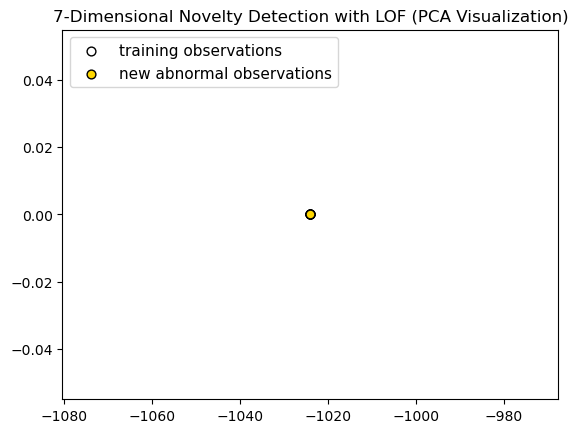

In [ ]:

import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

np.random.seed(42)
X_train = np.array(X_train)

# fit the model for novelty detection
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)

# Predict on test and outlier data
y_pred_outliers = clf.predict(X_outliers)
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size



In [66]:
print(y_pred_outliers)

[1]


Test if it works when smaller features change

In [ ]:
cursor.execute("SELECT os, screen_resolution, timezone, language, pixel_ratio, cookies_enabled, cpu_cores FROM fingerprints WHERE user_ID = 8")
existing_fingerprints = cursor.fetchall()

X_train = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]),
            fp[4], int(fp[5]), int(fp[6])
        ] for fp in existing_fingerprints[:-2]
    ]

X_outliers = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]),
            1, 0, 8
        ] for fp in existing_fingerprints[-1:]
    ]

print(X_train)

[[-3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 1.25, 1, 16], [-3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 1.25, 1, 16], [-3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 1.25, 1, 16], [-3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 1.25, 1, 16], [-3653407468025482990, 9202394690468201488, -3965214259639462322, -6049288712134895825, 1.25, 1, 16]]


In [70]:
X_train = np.array(X_train)

# fit the model for novelty detection
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)

# Predict on test and outlier data
y_pred_outliers = clf.predict(X_outliers)
print(y_pred_outliers)

[1]


c:\Users\phili\miniconda3\envs\DigitalBank\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [71]:
similarity = cosine_similarity(X_outliers, X_train)
print(np.mean(similarity))

1.0


Only use hashed features due to negligible affect on prediction

In [83]:
cursor.execute("SELECT browser, os, screen_resolution, timezone, language, plugins FROM fingerprints WHERE user_ID = 8")
existing_fingerprints = cursor.fetchall()

X_train = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]), hash(fp[4]), hash(fp[5]) 
        ] for fp in existing_fingerprints[:-2]
    ]

X_outliers = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]), hash(fp[4]), hash(fp[5]) 
        ] for fp in existing_fingerprints[-1:]
    ]


In [84]:
X_train = np.array(X_train)

# fit the model for novelty detection
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)

# Predict on test and outlier data
y_pred_outliers = clf.predict(X_outliers)
print(y_pred_outliers)

[1]


c:\Users\phili\miniconda3\envs\DigitalBank\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (5). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


In [82]:
similarity = cosine_similarity(X_outliers, X_train)
print(np.mean(similarity))

0.9757661409666125


Try on a different login

In [ ]:
cursor.execute("SELECT browser, os, screen_resolution, timezone, language, plugins FROM fingerprints WHERE user_ID = 63")
existing_fingerprints = cursor.fetchall()

X_train = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]), hash(fp[4]), hash(fp[5]) 
        ] for fp in existing_fingerprints[:-2]
    ]

X_outliers = [
        [
            hash(fp[0]), hash(fp[1]), hash(fp[2]), hash(fp[3]), hash(fp[4]), hash(fp[5]) 
        ] for fp in existing_fingerprints[-1:]
    ]



6


In [92]:
X_train = np.array(X_train)

# fit the model for novelty detection
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(X_train)

# Predict on test and outlier data
y_pred_outliers = clf.predict(X_outliers)
print(y_pred_outliers)

[1]


c:\Users\phili\miniconda3\envs\DigitalBank\Lib\site-packages\sklearn\neighbors\_lof.py:282: UserWarning: n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(
